In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# *Step:1* Data Loading

In [2]:
# Loading Data
train  = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
movies = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
train.shape

(162758, 5)

In [3]:
feature_list = train.columns[:-1].values
label = [train.columns[-1]]

print ("Feature list:", feature_list)
print ("Label:", label)

Feature list: ['movieid' 'reviewerName' 'isFrequentReviewer' 'reviewText']
Label: ['sentiment']


In [4]:
feature_list = movies.columns[:-1].values
print ("Feature list:", feature_list)

Feature list: ['movieid' 'title' 'audienceScore' 'rating' 'ratingContents'
 'releaseDateTheaters' 'releaseDateStreaming' 'runtimeMinutes' 'genre'
 'originalLanguage' 'director' 'boxOffice' 'distributor']


# *Step 2:* Data Preprocessing

### Choosing row which have minimum null values within specific movieid

In [5]:
# Choosing those rows which have minimum null values per movieid

# Calculate the null counts for each row
null_counts = movies.isnull().sum(axis=1)

min_null_counts_per_movieid = movies.groupby('movieid')['movieid'].transform(lambda x: null_counts[x.index].min())

# Create a boolean mask for rows with minimum null counts within each 'movieid' group
mask = null_counts == min_null_counts_per_movieid

movies_filtered_rows = movies[mask]

movies = pd.DataFrame(movies_filtered_rows)

##### This method is decreasing null values

## Remove Duplicated

In [6]:
train.drop_duplicates(inplace = True)
movies.drop_duplicates(subset=['movieid'], inplace = True)

In [7]:
# Shape after removing duplicates
print(train.shape)
print(movies.shape)

(161640, 5)
(126404, 14)


## Joining both data

In [8]:
data = pd.merge(train, movies, on="movieid", how="left")
data.shape

(161640, 18)

In [9]:
test = pd.merge(test, movies, on="movieid", how="left")
test.shape

(55315, 17)

## Saperate Features and Label

In [10]:
X = data.drop(['sentiment','movieid','title', 'releaseDateTheaters', 'releaseDateStreaming', 'director', 'soundType'],axis = 1)
y =  data['sentiment']

In [11]:
# Selected Columns
X.columns.values

array(['reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'ratingContents', 'runtimeMinutes',
       'genre', 'originalLanguage', 'boxOffice', 'distributor'],
      dtype=object)

In [12]:
final_x_test = test.drop([ 'movieid','title', 'releaseDateTheaters', 'releaseDateStreaming', 'director', 'soundType'],axis = 1)

# Renaming from isTopCritic to isFrequentReviewer
final_x_test.rename(columns={'isTopCritic': 'isFrequentReviewer'}, inplace=True)

## Spliting data

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size = 0.2,  random_state = 0)

## Boxoffice column modification

In [14]:
# Converting into K(thousands) values
X_train['boxOffice'] = X_train['boxOffice'].replace({'\$': '', 'M': 'e3', 'K': ''}, regex=True).astype(float)
X_test['boxOffice'] = X_test['boxOffice'].replace({'\$': '', 'M': 'e3', 'K': ''}, regex=True).astype(float)
final_x_test['boxOffice'] = final_x_test['boxOffice'].replace({'\$': '', 'M': 'e3', 'K': ''}, regex=True).astype(float)

## Handling missing values

In [15]:
#  % of missing values
round((X_train.isnull().sum() / len(X_train)) * 100,2)

reviewerName           0.00
isFrequentReviewer     0.00
reviewText             3.95
audienceScore          1.93
rating                28.08
ratingContents        28.08
runtimeMinutes         0.46
genre                  0.32
originalLanguage       0.50
boxOffice             20.91
distributor           13.42
dtype: float64

In [16]:
# Importing Libraries for handling missing values using ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129312 entries, 5578 to 43567
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   reviewerName        129312 non-null  object 
 1   isFrequentReviewer  129312 non-null  bool   
 2   reviewText          124206 non-null  object 
 3   audienceScore       126812 non-null  float64
 4   rating              93000 non-null   object 
 5   ratingContents      93000 non-null   object 
 6   runtimeMinutes      128714 non-null  float64
 7   genre               128898 non-null  object 
 8   originalLanguage    128661 non-null  object 
 9   boxOffice           102274 non-null  float64
 10  distributor         111959 non-null  object 
dtypes: bool(1), float64(3), object(7)
memory usage: 11.0+ MB


In [18]:
trf1 = ColumnTransformer([
    ('mean', SimpleImputer(strategy = 'median'),[3,6,9]), 
    ('most', SimpleImputer(strategy = 'most_frequent'),[0,1,2,4,5,7,8,10] )
])

In [19]:
# Transforming X_train
X_train = pd.DataFrame(trf1.fit_transform(X_train),columns = ['audienceScore','runtimeMinutes','boxOffice','reviewerName', 'isFrequentReviewer','reviewText', 'rating', 'ratingContents', 'genre', 'originalLanguage','distributor' ])

# Transforming X_test
X_test = pd.DataFrame(trf1.transform(X_test),columns = ['audienceScore','runtimeMinutes','boxOffice', 'reviewerName', 'isFrequentReviewer','reviewText', 'rating', 'ratingContents', 'genre', 'originalLanguage', 'distributor' ])

# Transforming final_x_test
final_x_test = pd.DataFrame(trf1.transform(final_x_test),columns = ['audienceScore','runtimeMinutes','boxOffice', 'reviewerName','isFrequentReviewer','reviewText', 'rating', 'ratingContents', 'genre', 'originalLanguage','distributor' ])

### Text Prepeocessing

In [20]:
import re

# Function for removing non-alphanumeric characters and extra whitespace
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply text cleaning to 'reviewText'
X_train['reviewText'] = X_train['reviewText'].apply(clean_text)
X_test['reviewText'] = X_test['reviewText'].apply(clean_text)
final_x_test['reviewText'] = final_x_test['reviewText'].apply(clean_text)

In [21]:
# Converting genre column to list of String for applying MultiLabelBinarizer 
X_train['genre'] = X_train['genre'].apply(lambda x: x.split(', '))
X_test['genre'] = X_test['genre'].apply(lambda x: x.split(', '))
final_x_test['genre'] = final_x_test['genre'].apply(lambda x: x.split(', '))

In [22]:
# Converting ratingContents column to  converting into list of String for applying  MultiLabelBinarizer 

def convert_to_list(string_rep):
    string_rep = string_rep.strip("[]")
    return [item.strip().strip("'") for item in string_rep.split(",")]

# Apply the function to the 'ratingContents' column
X_train['ratingContents'] = X_train['ratingContents'].apply(convert_to_list)
X_test['ratingContents'] = X_test['ratingContents'].apply(convert_to_list)
final_x_test['ratingContents'] = final_x_test['ratingContents'].apply(convert_to_list)

## Converting Data types

In [23]:
# Converting Numerical-columns back to float of X_train
X_train['boxOffice'] = X_train['boxOffice'].astype(float)
X_train['audienceScore'] = X_train['audienceScore'].astype(float)
X_train['runtimeMinutes'] = X_train['runtimeMinutes'].astype(float)

In [24]:
# Converting Numerical-columns back to float of X_test
X_test['boxOffice'] = X_test['boxOffice'].astype(float)
X_test['audienceScore'] = X_test['audienceScore'].astype(float)
X_test['runtimeMinutes'] = X_test['runtimeMinutes'].astype(float)

In [25]:
# Converting Numerical-columns back to float of final_x_test
final_x_test['boxOffice'] = final_x_test['boxOffice'].astype(float)
final_x_test['audienceScore'] = final_x_test['audienceScore'].astype(float)
final_x_test['runtimeMinutes'] = final_x_test['runtimeMinutes'].astype(float)

# *Step 3:* Exploratory Data Analysis (EDA)

## Visualize the preprocessed data

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

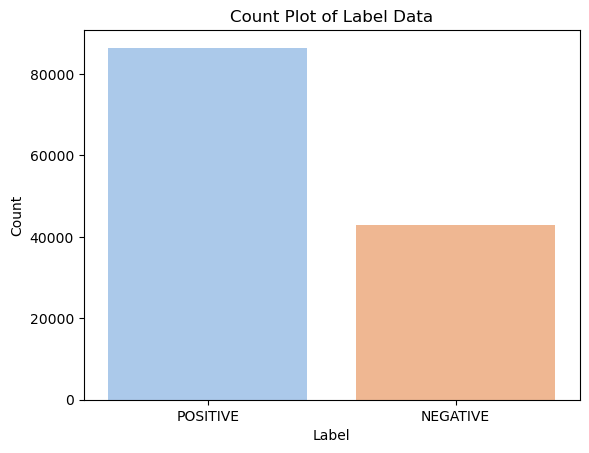

In [27]:
# Countplot
sns.countplot(x=y_train, palette='pastel')
plt.title('Count Plot of Label Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [28]:
# Label Distribution in %
y_train.value_counts(normalize=True) * 100

POSITIVE    66.847624
NEGATIVE    33.152376
Name: sentiment, dtype: float64

* Positive labels are more then Negative

Text(0, 0.5, 'Count')

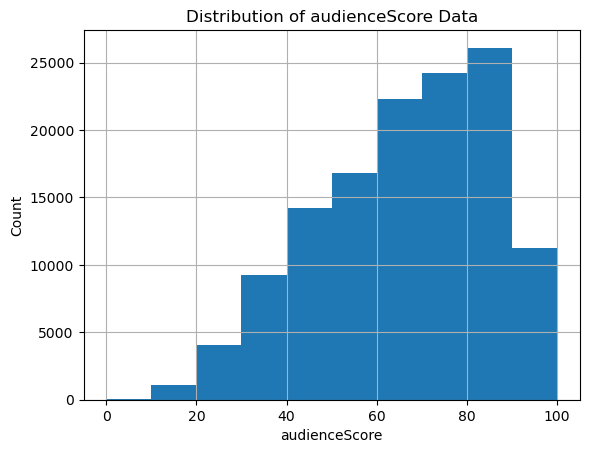

In [29]:
# Distribution of audienceScore Data
X_train.audienceScore.hist()
plt.title('Distribution of audienceScore Data')
plt.xlabel('audienceScore')
plt.ylabel('Count')

* audienceScore range from 0 to 100
* Left skewed distribution

Text(0, 0.5, 'Count')

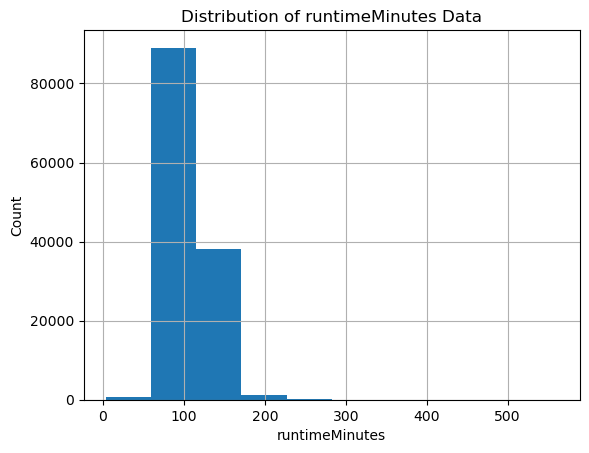

In [30]:
# Distribution of runtimeMinutes Data
X_train['runtimeMinutes'].hist()
plt.title('Distribution of runtimeMinutes Data')
plt.xlabel('runtimeMinutes')
plt.ylabel('Count')

* runtimeMinutes range from 0 to 500 
* But majority of data belong between 50 and 180

Text(0, 0.5, 'Count')

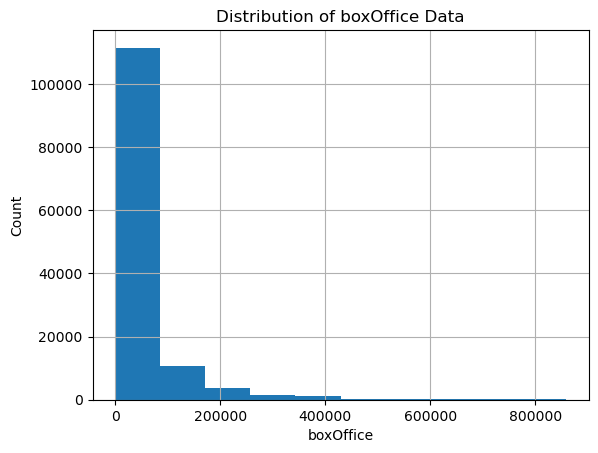

In [31]:
# Distribution of boxOffice Data
X_train['boxOffice'].hist()
plt.title('Distribution of boxOffice Data')
plt.xlabel('boxOffice')
plt.ylabel('Count')

* boxOffice range from 0 to 800000
* follow exponential distribution

### Few observations based on these plots:
* Features are at different scales.
* Features have different distributions

## Looking Mathematically

In [32]:
X_train.describe()

,audienceScore,runtimeMinutes,boxOffice
count,129312.000000,129312.000000,129312.000000
mean,65.728935,108.504972,43114.023506
std,19.135219,20.860155,80707.998237
min,0.000000,4.000000,0.000000
25%,52.000000,95.000000,2600.000000
50%,69.000000,105.000000,15900.000000
75%,82.000000,119.000000,43100.000000
max,100.000000,561.000000,858400.000000


## Correlation between columns

<Axes: >

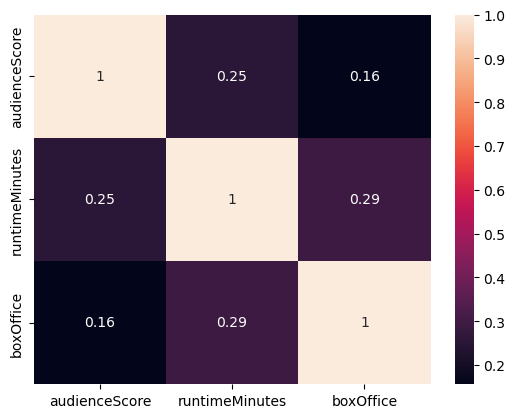

In [33]:
corr_matrix = X_train.corr(numeric_only =True)
sns.heatmap(corr_matrix, annot=True)

* boxoffice & runtimeMinutes have positive correlation

## Checking for Outliers

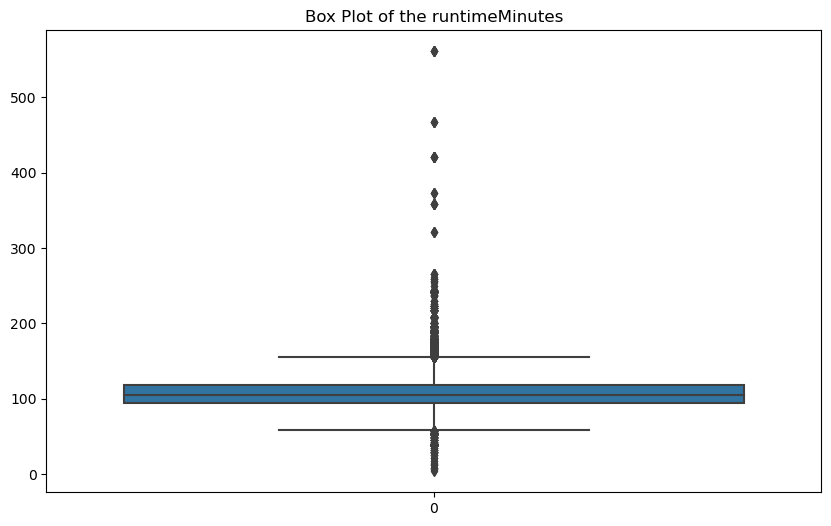

In [34]:
# Create a box plot for runtimeMinutes
plt.figure(figsize=(10, 6))
sns.boxplot(X_train['runtimeMinutes'])
plt.title("Box Plot of the runtimeMinutes")
plt.show()

In [35]:
# Calculating percentage of data belongs to outliers, based on the box plot
q1 = X_train['runtimeMinutes'].quantile(0.25)
q3 = X_train['runtimeMinutes'].quantile(0.75)
iqr = q3 - q1

lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr

outliers = (X_train['runtimeMinutes'] < lower_threshold) | (X_train['runtimeMinutes'] > upper_threshold)
percentage_outliers = (sum(outliers) / len(outliers)) * 100

# Display the results
print(f"Percentage of Outliers: {percentage_outliers:.2f}%")

Percentage of Outliers: 3.10%


* Percentage of Outliers is small so it can be ignored

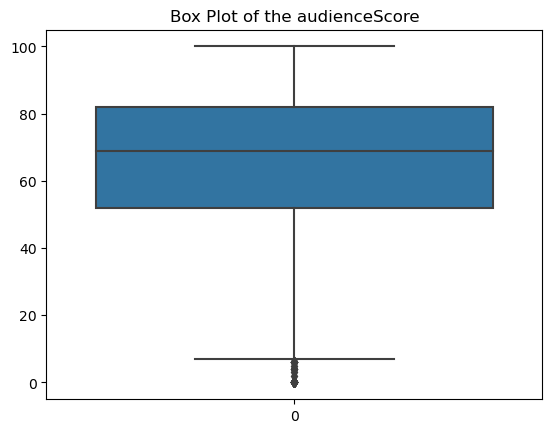

In [36]:
# Creating box plot for audienceScore
sns.boxplot(data=X_train['audienceScore'])
plt.title("Box Plot of the audienceScore")
plt.show()

In [37]:
# Calculating percentage of data belongs to outliers based on the box plot
q1 = X_train['audienceScore'].quantile(0.25)
q3 = X_train['audienceScore'].quantile(0.75)
iqr = q3 - q1

lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr

outliers = (X_train['audienceScore'] < lower_threshold) | (X_train['audienceScore'] > upper_threshold)
percentage_outliers = (sum(outliers) / len(outliers)) * 100
# Display the results
print(f"Percentage of Outliers: {percentage_outliers:.2f}%")

Percentage of Outliers: 0.03%


* Percentage of Outliers is small so it can be ignored

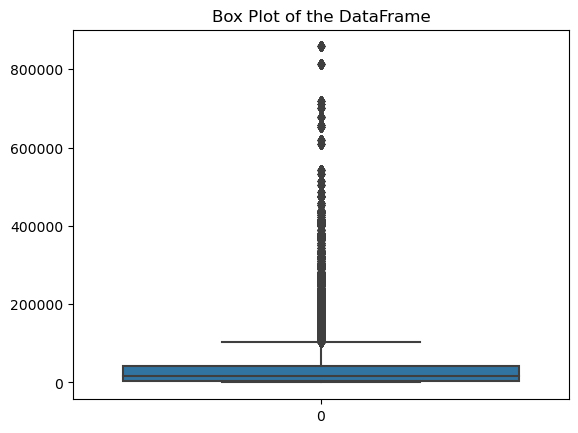

In [38]:
# Creating box plot for boxOffice
sns.boxplot(data=X_train['boxOffice'])
plt.title("Box Plot of the DataFrame")
plt.show()

In [39]:
# Calculating percentage of data belongs to outliers based on the box plot
q1 = X_train['boxOffice'].quantile(0.25)
q3 = X_train['boxOffice'].quantile(0.75)
iqr = q3 - q1

lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr

outliers = (X_train['boxOffice'] < lower_threshold) | (X_train['boxOffice'] > upper_threshold)
percentage_outliers = (sum(outliers) / len(outliers)) * 100
# Display the results
print(f"Percentage of Outliers: {percentage_outliers:.2f}%")

Percentage of Outliers: 11.37%


* Percentage of Outliers is large so it should be handle

### Dealing with outliears

In [40]:
# Capping values outside the specified range with the corresponding bound.

X_train['boxOffice'] =X_train['boxOffice'].clip(lower = lower_threshold,upper = upper_threshold)
X_test['boxOffice'] =X_test['boxOffice'].clip(lower = lower_threshold,upper = upper_threshold)
final_x_test['boxOffice'] =final_x_test['boxOffice'].clip(lower = lower_threshold,upper = upper_threshold)

<Axes: >

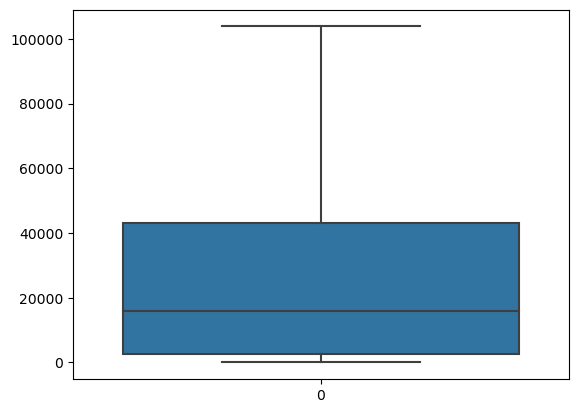

In [41]:
sns.boxplot(data=X_train['boxOffice'])

# *Step:4* : Feature Engineering

##  *(a) Feature Scaling* & *(b)  Encoding Categorical Features* 

In [42]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129312 entries, 0 to 129311
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   audienceScore       129312 non-null  float64
 1   runtimeMinutes      129312 non-null  float64
 2   boxOffice           129312 non-null  float64
 3   reviewerName        129312 non-null  object 
 4   isFrequentReviewer  129312 non-null  object 
 5   reviewText          129312 non-null  object 
 6   rating              129312 non-null  object 
 7   ratingContents      129312 non-null  object 
 8   genre               129312 non-null  object 
 9   originalLanguage    129312 non-null  object 
 10  distributor         129312 non-null  object 
dtypes: float64(3), object(8)
memory usage: 10.9+ MB


In [44]:
# dropping reviewText column
X_train_w = X_train.drop(['reviewText'], axis = 1)
X_test_w = X_test.drop(['reviewText'], axis = 1)
final_x_test_w = final_x_test.drop(['reviewText'], axis = 1)

### Encoding genre and ratingContents column using MultiLabelBinarizer

In [45]:
# Apply MultiLabelBinarizer to genre separately
mlb = MultiLabelBinarizer()
multi_label_X_train_w1 = mlb.fit_transform(X_train_w['genre'])
multi_label_X_test_w1 = mlb.transform(X_test_w['genre'])
multi_label_final_x_test_w1 = mlb.transform(final_x_test_w['genre'])

# Convert the transformed genre to a DataFrame for concatenation
multi_label_X_train_w1 = pd.DataFrame(multi_label_X_train_w1, columns=mlb.classes_)
multi_label_X_test_w1 = pd.DataFrame(multi_label_X_test_w1, columns=mlb.classes_)
multi_label_final_x_test_w1 = pd.DataFrame(multi_label_final_x_test_w1, columns=mlb.classes_)

# Droping the genre column from the DataFrame
X_train_w.drop(columns=['genre'], inplace=True)
X_test_w.drop(columns=['genre'], inplace=True)
final_x_test_w.drop(columns=['genre'], inplace=True)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Gay & lesbian', 'News'] will be ignored
  warnings.warn(


In [46]:
# Apply MultiLabelBinarizer to the ratingContents column separately
mlb = MultiLabelBinarizer()
multi_label_X_train_w2 = mlb.fit_transform(X_train_w['ratingContents'])
multi_label_X_test_w2 = mlb.transform(X_test_w['ratingContents'])
multi_label_final_x_test_w2 = mlb.transform(final_x_test_w['ratingContents'])

# Convert the transformed genre to a DataFrame for concatenation
multi_label_X_train_w2 = pd.DataFrame(multi_label_X_train_w2, columns=mlb.classes_)
multi_label_X_test_w2 = pd.DataFrame(multi_label_X_test_w2, columns=mlb.classes_)
multi_label_final_x_test_w2 = pd.DataFrame(multi_label_final_x_test_w2, columns=mlb.classes_)

# Droping the ratingContents column from the DataFrame
X_train_w.drop(columns=['ratingContents'], inplace=True)
X_test_w.drop(columns=['ratingContents'], inplace=True)
final_x_test_w.drop(columns=['ratingContents'], inplace=True)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Brief Violence/Bloody Images', 'Disturbing Gory Violence', 'Disturbing Rape Content', 'Elements of Theme', 'Horror Violence and Language', 'Pervasive Violence', 'Some Racial Tension/Violence', 'Some Violent Sequences'] will be ignored
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Brief Violence/Bloody Images', 'Disturbing Gory Violence', 'Disturbing Rape Content', 'Elements of Theme', 'Horror Violence and Language', 'Pervasive Smoking', 'Pervasive Violence', 'Some Racial Tension/Violence', 'Some Teen Marijuana Use', 'Some Violent Sequences'] will be ignored
  warnings.warn(


In [47]:
X_train_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129312 entries, 0 to 129311
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   audienceScore       129312 non-null  float64
 1   runtimeMinutes      129312 non-null  float64
 2   boxOffice           129312 non-null  float64
 3   reviewerName        129312 non-null  object 
 4   isFrequentReviewer  129312 non-null  object 
 5   rating              129312 non-null  object 
 6   originalLanguage    129312 non-null  object 
 7   distributor         129312 non-null  object 
dtypes: float64(3), object(5)
memory usage: 7.9+ MB


### Encoding reviewText Column using TfidfVectorizer


In [48]:
# Storing text column into text_train dataFrame
text_train = X_train[['reviewText']]
text_test = X_test[['reviewText']]
final_text_test = final_x_test[['reviewText']]

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english') 

# fiting and transforming
X_train_vectorized = vectorizer.fit_transform(text_train['reviewText'])
X_test_vectorized = vectorizer.transform(text_test['reviewText'])
final_x_test_vectorized = vectorizer.transform(final_text_test['reviewText'])
final_x_test_vectorized.shape

(55315, 79379)

### Scaling and Encoding remaining column using MinMaxScaler and OneHotEncoder respectively

In [50]:
# Creating  ColumnTransformer
trf2 = ColumnTransformer([
    ('scal', MinMaxScaler(),[0,1,2]),
    ('ohe',OneHotEncoder(handle_unknown = 'ignore'), [3,4,6,7] ),
    ('ord', OrdinalEncoder(), [5])
])

In [51]:
# Transforming data
X_train_w = trf2.fit_transform(X_train_w)
X_test_w = trf2.transform(X_test_w)
final_x_test_w = trf2.transform(final_x_test_w)

# Connecting all Transformed Columns in one dataFrame

In [52]:
# New
from scipy.sparse import csr_matrix, vstack, hstack
train_data= hstack([X_train_w,X_train_vectorized,multi_label_X_train_w1,multi_label_X_train_w2 ] )
test_data = hstack([X_test_w,X_test_vectorized, multi_label_X_test_w1,multi_label_X_test_w2 ] )
final_test_data = hstack([final_x_test_w,final_x_test_vectorized , multi_label_final_x_test_w1,multi_label_final_x_test_w2] )

In [53]:
train_data.shape

(129312, 87193)

### Encoding Target Label

In [54]:
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

## Feature Selection using Chi2

In [55]:
# Converting sparse matrix  to DataFrame
df1 = pd.DataFrame.sparse.from_spmatrix(train_data)
df2 = pd.DataFrame.sparse.from_spmatrix(test_data)
df3 = pd.DataFrame.sparse.from_spmatrix(final_test_data)

In [56]:
from sklearn.feature_selection import SelectKBest, chi2

# Initialize SelectKBest with chi-squared test as the score function
kbest_selector = SelectKBest(score_func=chi2, k=10500)

kbest_selector.fit(df1, y_train)

# Get the selected feature indices
selected_feature_indices = kbest_selector.get_support(indices=True)

# Get the names of the selected features
selected_features = df1.columns[selected_feature_indices]

print("Selected Features:")
print(len(selected_feature_indices))

Selected Features:
10500


In [57]:
# Selecting bestfeatures from original DataFrame
train_data = df1[selected_feature_indices]
test_data = df2[selected_feature_indices]
final_test_data = df3[selected_feature_indices]

In [58]:
train_data.shape

(129312, 10500)

# *Step 5:* Model Selection and Training

In [59]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

In [60]:
# Training Models
models = [
    LogisticRegression(),
    SGDClassifier(alpha=0.0001, random_state=42),
    LinearSVC()
]

best_accuracy = 0
best_model = None

for model in models:
    model.fit(train_data, y_train)
    y_pred = model.predict(test_data)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Training Score: {model.score(train_data, y_train):.2f}")
    print(f"Testing Score: {accuracy:.2f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        print("(Best Model)")
    
    print("="*30)

print("Best Model:")
print(best_model)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: LogisticRegression
Training Score: 0.83
Testing Score: 0.81
(Best Model)
Model: SGDClassifier
Training Score: 0.81
Testing Score: 0.79
Model: LinearSVC
Training Score: 0.86
Testing Score: 0.82
(Best Model)
Best Model:
LinearSVC()


### From above observation
* LogisticRegression :- Simple model
* SGDClassifier and LinearSVC are overfited

In [61]:
# Storing Best Model in model
model = best_model

# *Step 6:* Model Evaluation

In [62]:
# Train data f1_micro Score
y_pred_tr = model.predict(train_data)
f1_micro = f1_score(y_train, y_pred_tr, average='micro')
f1_micro

0.8632841499628805

In [63]:
# Test data f1_micro Score
from sklearn.metrics import f1_score
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_micro

0.819382578569661

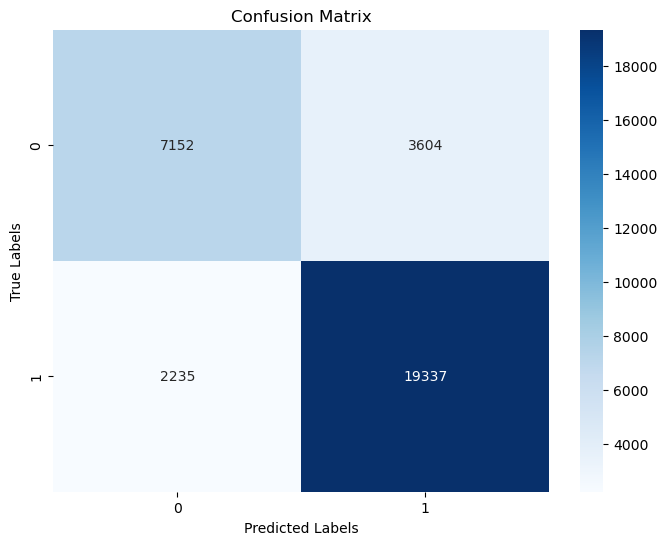

In [64]:
# Make predictions using the best model
best_y_pred = model.predict(test_data)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, best_y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

* True postive is 19337 
* True Negative is 7152

In [65]:
# Print classification report (includes precision, recall, F1-score, etc.)
print("Classification Report:")
print(classification_report(y_test, best_y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.66      0.71     10756
           1       0.84      0.90      0.87     21572

    accuracy                           0.82     32328
   macro avg       0.80      0.78      0.79     32328
weighted avg       0.82      0.82      0.82     32328



# *Step 6:* Hyperparameter tuning using RandomizedSearchCV

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [67]:
models = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(),
        'param_dist': {
            'model__C': [0.1, 1, 10],  
            'model__solver': ['newton-cg', 'liblinear'],
        }
    },
    {
        'name': 'SGD Classifier',
        'model': SGDClassifier(),
        'param_dist': {
            'model__alpha': [0.0001, 0.001, 0.01], 
        }
    },
    {
        'name': 'Linear SVC',
        'model': LinearSVC(),
        'param_dist': {
            'model__C': [0.01, 0.1, 1], 
            'model__penalty': ['l1', 'l2'],
        }
    },
]



for model_info in models:
    name = model_info['name']
    model = model_info['model']
    param_dist = model_info['param_dist']

    # Creating a pipeline
    pipe = Pipeline([
        ('model', model)
    ])

    # Perform randomized search with cross-validation
    randome_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                           n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=2)
    randome_search.fit(train_data, y_train)

    # Get the best parameters and the corresponding model
    best_params = randome_search.best_params_
    best_model = randome_search.best_estimator_

    # Evaluate the model on the testing set
    y_pred = best_model.predict(test_data)
    accuracy = accuracy_score(y_test, y_pred)

    # Print the results
    print(f"{name} - Best Parameters: {best_params}")
    print(f"{name} - Accuracy on Test Set: {accuracy:.4f}")
    print('-' * 50)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Logistic Regression - Best Parameters: {'model__solver': 'newton-cg', 'model__C': 10}
Logistic Regression - Accuracy on Test Set: 0.8189
--------------------------------------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SGD Classifier - Best Parameters: {'model__alpha': 0.0001}
SGD Classifier - Accuracy on Test Set: 0.7893
--------------------------------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validat

Linear SVC - Best Parameters: {'model__penalty': 'l2', 'model__C': 1}
Linear SVC - Accuracy on Test Set: 0.8194
--------------------------------------------------


### Choosing best model with best parameters

In [68]:
best_model = best_model.named_steps['model']

In [69]:
# Train data Score
y_pred_tr = best_model.predict(train_data)
f1_micro = f1_score(y_train, y_pred_tr, average='micro')
print('Train Score:',f1_micro)

Train Score: 0.8632841499628805


#### This Model is Overfitting

### Submission

In [70]:
final_y_pred = best_model.predict(final_test_data)

In [71]:
prediction = np.array(final_y_pred, dtype=object)
prediction[prediction == 0] = "NEGATIVE"
prediction[prediction == 1] = "POSITIVE"


In [72]:
submission = pd.DataFrame(columns = ['id', 'sentiment'])
submission['id']= [i for i in range(len(test))]
submission['sentiment'] = prediction

In [73]:
submission.shape

(55315, 2)

In [74]:
submission.to_csv('submission.csv',index = False)